# PLAN

- [x] Acquisition
    - [x] Investigate structure of Codeup's alumni portal site.
    - [x] Get requests from the site.
    - [x] Save responses to json.
- [x] Preparation
    - [x] Setup hired vs. available as target variable.
    - [x] Clean up and lemmatize the quotes.
- [x] Exploration
    - [x] Answer the following prompts:
        - [x] What are the most common words in quotes?
        - [x] What does the distribution of IDFs look like for the most common words?
        - [x] Does sentiment differ between hired and available students?
- [x] Modeling
    - [x] Transform the data for machine learning; predit hire vs. available.
    - [x] Fit several models using different text representations.
    - [x] Build a function that will take in the text of a README file, and makes a prediction of language.
- [x] Delivery
    - [x] Github repo
        - [x] This notebook.
        - [x] Documentation within the notebook.
        - [x] README file in the repo.
        - [] Python scripts if applicable.

# ENVIRONMENT

In [93]:
import os
import sys

import pandas as pd
import numpy as np
import re
import json
import unicodedata
import nltk
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from afinn import Afinn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

ADDITIONAL_STOPWORDS = ['email',
                        'social',
                        'twitter',
                        'github',
                        'linkedin',
                        'personal',
                        'site',
                        'Email',
                        'Social',
                        'Twitter',
                        'Github',
                        'Linkedin',
                        'Personal',
                        'Site',
                        '\n'
                       ]

# ACQUIRE

In [2]:
# We're going to scrape Codeup's Alumni Portal.
# https://alumni.codeup.com/

In [3]:
def get_codeup_alumnus(url):
    """
    This function takes a student's page url and returns a
    dictionary that contains the quote and hiring status.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    quote = soup.find('div', class_='col-md-6')
    status = soup.find('div', class_=re.compile("^shadowed hire_status"))
    student_num = soup.find('link', rel='canonical')
    grad_date = soup.select('body > div.container > div > h1 > small')
    
    if (int((student_num.get('href')).split('/')[4])) < 613:
        
        d = dict()
        if quote is None:
            d['quote'] = 'No quote.'
        else:
            d['quote'] = quote.text
        if status is None:
            d['status'] = 'Unknown.'
        else:
            d['status'] = status.text
        return d

In [4]:
# This line to test out the function.
# get_codeup_alumnus('https://alumni.codeup.com/students/613')

In [5]:
def get_codeup_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual alumni listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', attrs={'href': re.compile("^https://alumni.codeup.com/students/")}):
        links.append(link.get('href'))
    return links

In [6]:
# This line to test out the function.
# get_codeup_links('https://alumni.codeup.com/?page=1')

In [7]:
def get_all_codeup_alumni(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_codeup_links(path + '?page=' + str(page)))
    return all_links

In [8]:
# This line to test out the function.
# get_all_codeup_alumni('https://alumni.codeup.com/', 15)

In [9]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [10]:
def get_codeup_alumni(url, num_pages, cache=True):
    if cache and os.path.exists('codeup_alumni.json'):
        alumni_data = json.load(open('codeup_alumni.json'))
    else:
        data = get_all_codeup_alumni(url, num_pages)
        alumni_data = []
        for value in traverse(data):
            print(value)
            alumni_data.append(get_codeup_alumnus(value))
        json.dump(alumni_data, open('codeup_alumni.json', 'w'))
    return alumni_data

In [11]:
# Bringing it all together chaining...
corpus = get_codeup_alumni('https://alumni.codeup.com/', 15, cache=True)
corpus

[{'quote': '\n"The price of doing the same old thing is far higher than the price of change."\nSocial\n\n  Email\n\n\n  Github\n\n\n  LinkedIn\n\n',
  'status': 'Available'},
 {'quote': '\n"Talent wins games, but teamwork and intelligence win championships."\nSocial\n\n  Email\n\n\n  Github\n\n\n  LinkedIn\n\n',
  'status': 'Available'},
 {'quote': '\n" Challenges are what make life interesting and overcoming them is what makes life meaningful."\nSocial\n\n  Email\n\n\n  Github\n\n\n  LinkedIn\n\n',
  'status': 'Available'},
 {'quote': '\n"Keep your head up in failure, and your head down in success. - Jerry Seinfeld"\nSocial\n\n  Email\n\n\n  Github\n\n\n  LinkedIn\n\n',
  'status': 'Available'},
 {'quote': '\n"I think life is far too short to concentrate on your past. I rather look into the future. — Lou Reed"\nSocial\n\n  Email\n\n\n  Github\n\n\n  LinkedIn\n\n',
  'status': 'Available'},
 {'quote': '\n"It always seems impossible until it\'s done. - Nelson Mandela"\nSocial\n\n  Email

In [12]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

# PREPARE

In [13]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", '', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english')

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

#     print('Removed {} stopwords'.format(len(words) - len(filtered_words)))

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):
    
#     article_stemmed = stem(basic_clean(article['quote']))
    article_stemmed = basic_clean(article['quote'])
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

In [14]:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

(495, 5)

In [15]:
df = df[['quote', 'status']]
df

,quote,status
0,"\n""The price of doing the same old thing is fa...",Available
1,"\n""Talent wins games, but teamwork and intelli...",Available
2,"\n"" Challenges are what make life interesting ...",Available
3,"\n""Keep your head up in failure, and your head...",Available
4,"\n""I think life is far too short to concentrat...",Available
5,"\n""It always seems impossible until it's done....",Available
6,"\n""We can only see a short distance...but we c...",Available
7,"\n""There is a way out of every box, a solution...",Available
8,"\n""Erroneous assumptions can be disastrous. — ...",Available
9,"\n""I'm not superstitious, but I'm a little sti...",Available


In [16]:
status = pd.concat([df.status.value_counts(),
                    df.status.value_counts(normalize=True)], axis=1)
status.columns = ['n', 'ratio']
status

,n,ratio
Hired,401,0.810101
Available,82,0.165657
Freelancing,5,0.010101
Hired but looking,2,0.004040
HIred,2,0.004040
Part-time,1,0.002020
Hired but looking!,1,0.002020
Hired>College,1,0.002020


In [17]:
# removing all rows that has 'No language specified.'
df = df[df.status != 'Unknown.']

In [18]:
df.shape

(495, 2)

In [19]:
status = pd.concat([df.status.value_counts(),
                    df.status.value_counts(normalize=True)], axis=1)
status.columns = ['n', 'ratio']
status

,n,ratio
Hired,401,0.810101
Available,82,0.165657
Freelancing,5,0.010101
Hired but looking,2,0.004040
HIred,2,0.004040
Part-time,1,0.002020
Hired but looking!,1,0.002020
Hired>College,1,0.002020


In [20]:
df.loc[df.status != 'Available', 'new_status'] = 'Hired'
df.loc[df.status == 'Available', 'new_status'] = 'Not Hired'

In [21]:
df = df.drop(columns=['status'])
df = df.rename(index=str, columns={"new_status": "status"})

In [22]:
df.head(100)

,quote,status
0,"\n""The price of doing the same old thing is fa...",Not Hired
1,"\n""Talent wins games, but teamwork and intelli...",Not Hired
2,"\n"" Challenges are what make life interesting ...",Not Hired
3,"\n""Keep your head up in failure, and your head...",Not Hired
4,"\n""I think life is far too short to concentrat...",Not Hired
5,"\n""It always seems impossible until it's done....",Not Hired
6,"\n""We can only see a short distance...but we c...",Not Hired
7,"\n""There is a way out of every box, a solution...",Not Hired
8,"\n""Erroneous assumptions can be disastrous. — ...",Not Hired
9,"\n""I'm not superstitious, but I'm a little sti...",Not Hired


# EXPLORE

In [23]:
status = pd.concat([df.status.value_counts(),
                    df.status.value_counts(normalize=True)], axis=1)
status.columns = ['n', 'ratio']
status

,n,ratio
Hired,413,0.834343
Not Hired,82,0.165657


In [24]:
hired_alumni = clean(' '.join(df[df.status == 'Hired'].quote))
not_hired_alumni = clean(' '.join(df[df.status == 'Not Hired'].quote))
all_alumni = clean(' '.join(df.quote))

In [25]:
hired_freq = pd.Series(hired_alumni).value_counts()
not_hired_freq = pd.Series(not_hired_alumni).value_counts()
all_freq = pd.Series(all_alumni).value_counts()

In [26]:
hired_freq.head()

work     28
make     25
thing    24
life     22
one      21
dtype: int64

In [27]:
not_hired_freq.head()

failure    8
success    8
life       8
win        6
make       5
dtype: int64

In [28]:
word_counts = (pd.concat([all_freq, hired_freq, not_hired_freq], axis=1, sort=True)
                .set_axis(['all', 'hired', 'not hired'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(20)

,all,hired,not hired
1,1,1,0
10,2,2,0
100,3,3,0
10000,2,2,0
20year,1,1,0
23,1,1,0
80,1,1,0
90,2,2,0
ability,2,2,0
abstraction,1,1,0


### _What are the most frequently occuring words?_

In [29]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,hired,not hired
work,32,28,4
life,30,22,8
make,30,25,5
thing,29,24,5
never,25,21,4
one,24,21,3
success,24,16,8
dont,21,18,3
way,20,17,3
failure,19,11,8


### _Are there any words that uniquely identify a hired or not hired quote?_

In [30]:
pd.concat([word_counts[word_counts['not hired'] == 0].sort_values(by='hired').tail(9),
           word_counts[word_counts['hired'] == 0].sort_values(by='not hired').tail(9)])

,all,hired,not hired
experience,9,9,0
get,9,9,0
become,10,10,0
new,10,10,0
best,11,11,0
take,11,11,0
want,12,12,0
code,14,14,0
team,18,18,0
loyalty,2,0,2


Text(0.5, 1.0, 'Proportion of Not Hired v. Hired for the 20 most common words')

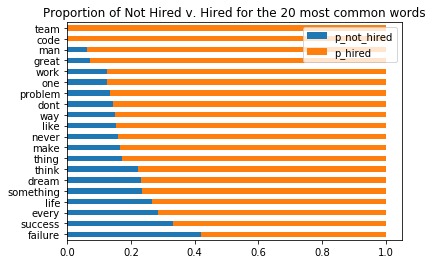

In [31]:
# figure out the percentage of hired v. not hired
(word_counts
 .assign(p_not_hired=word_counts['not hired'] / word_counts['all'],
         p_hired=word_counts['hired'] / word_counts['all'])
 .sort_values(by='all')
 [['p_not_hired', 'p_hired']]
 .tail(20)
 .sort_values('p_hired')
 .plot.barh(stacked=True))

plt.title('Proportion of Not Hired v. Hired for the 20 most common words')

In [32]:
# (word_counts
#  [(word_counts['not hired'] > 10) & (word_counts['hired'] > 10)]
#  .assign(ratio=lambda df: df['not hired'] / (df['hired'] + .01))
#  .sort_values(by='ratio')
#  .pipe(lambda df: pd.concat([df.head(), df.tail()])))

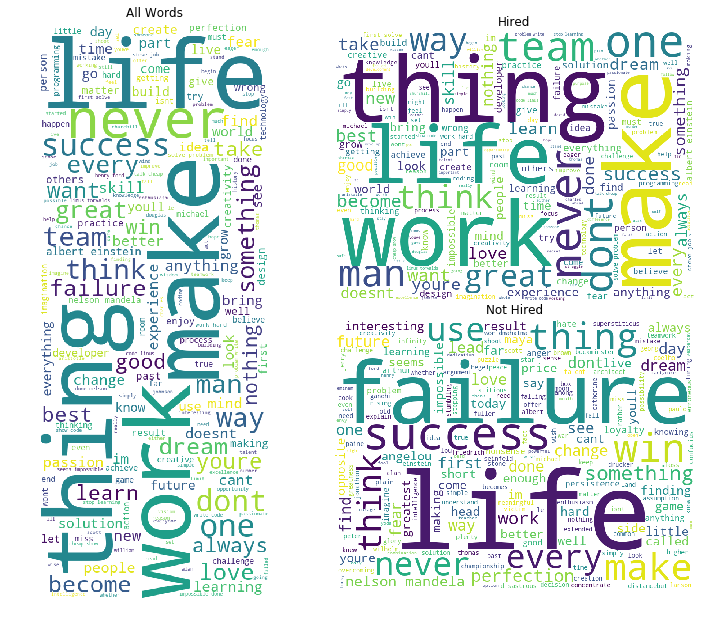

In [33]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_alumni))
hired_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(hired_alumni))
not_hired_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(not_hired_alumni))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(hired_cloud)
axs[2].imshow(not_hired_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Hired')
axs[2].set_title('Not Hired')

for ax in axs: ax.axis('off')

In [34]:
top_20_hired_bigrams = (pd.Series(nltk.ngrams(hired_alumni, 2))
                      .value_counts()
                      .head(20))

top_20_hired_bigrams.head()

(albert, einstein)    6
(solve, problem)      5
(work, hard)          5
(linus, torvalds)     4
(steve, job)          4
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

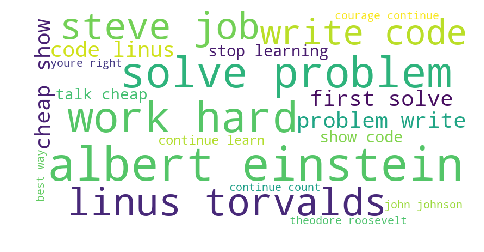

In [35]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_hired_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [36]:
top_20_not_hired_bigrams = (pd.Series(nltk.ngrams(not_hired_alumni, 2))
                      .value_counts()
                      .head(20))

top_20_not_hired_bigrams.head()

(nelson, mandela)    3
(make, life)         3
(done, nelson)       2
(hard, work)         2
(youre, making)      2
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

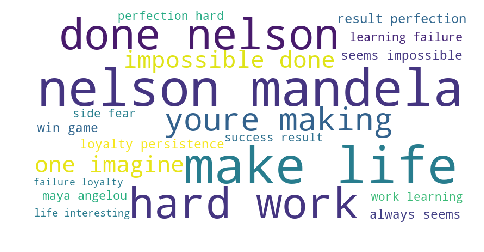

In [37]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_not_hired_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [38]:
top_20_hired_bigrams = (pd.Series(nltk.ngrams(hired_alumni, 3))
                      .value_counts()
                      .head(20))

top_20_hired_bigrams.head()

(problem, write, code)     4
(talk, cheap, show)        4
(first, solve, problem)    4
(cheap, show, code)        4
(show, code, linus)        4
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

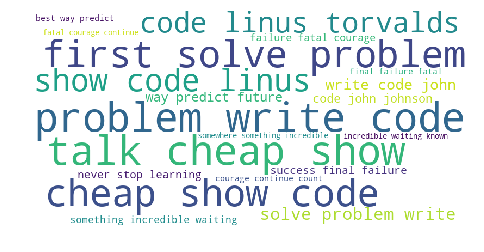

In [39]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_hired_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [40]:
top_20_not_hired_bigrams = (pd.Series(nltk.ngrams(not_hired_alumni, 3))
                      .value_counts()
                      .head(20))

top_20_not_hired_bigrams.head()

(success, result, perfection)    2
(always, seems, impossible)      2
(impossible, done, nelson)       2
(learning, failure, loyalty)     2
(hard, work, learning)           2
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

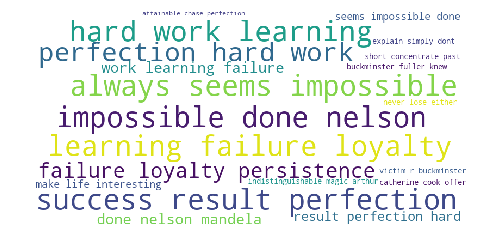

In [41]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_not_hired_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 1599.5, 999.5, -0.5)

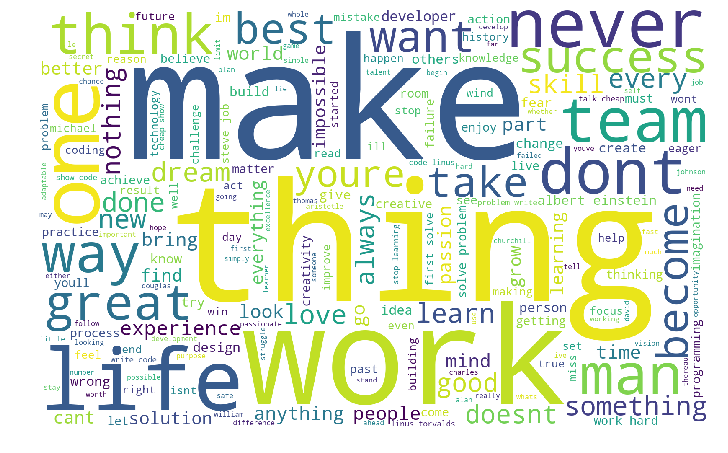

In [42]:
hired_cloud = WordCloud(background_color='white', height=1000, width=1600).generate(' '.join(hired_alumni))
plt.figure(figsize=(12, 10))
plt.imshow(hired_cloud)
plt.axis('off')

(-0.5, 1599.5, 999.5, -0.5)

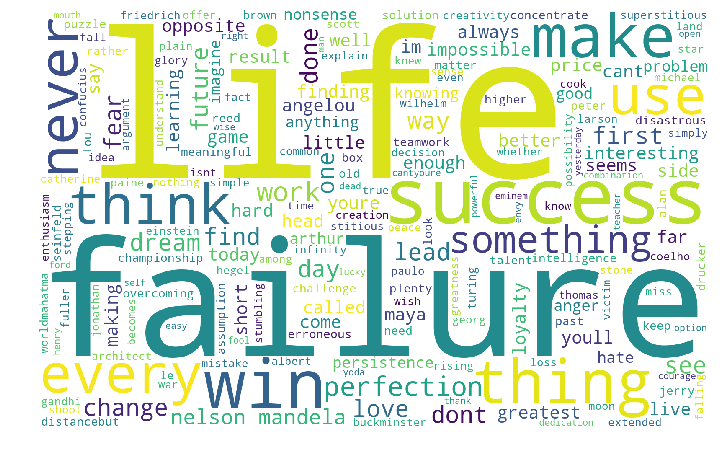

In [43]:
not_hired_cloud = WordCloud(background_color='white', height=1000, width=1600).generate(' '.join(not_hired_alumni))
plt.figure(figsize=(12, 10))
plt.imshow(not_hired_cloud)
plt.axis('off')

In [44]:
afinn = Afinn()

In [45]:
afinn.score('This is amazingly awesome')

4.0

In [46]:
df['sentiment'] = df.quote.apply(afinn.score)

In [47]:
df.head(20)

,quote,status,sentiment
0,"\n""The price of doing the same old thing is fa...",Not Hired,0.0
1,"\n""Talent wins games, but teamwork and intelli...",Not Hired,10.0
2,"\n"" Challenges are what make life interesting ...",Not Hired,4.0
3,"\n""Keep your head up in failure, and your head...",Not Hired,0.0
4,"\n""I think life is far too short to concentrat...",Not Hired,0.0
5,"\n""It always seems impossible until it's done....",Not Hired,0.0
6,"\n""We can only see a short distance...but we c...",Not Hired,0.0
7,"\n""There is a way out of every box, a solution...",Not Hired,2.0
8,"\n""Erroneous assumptions can be disastrous. — ...",Not Hired,-5.0
9,"\n""I'm not superstitious, but I'm a little sti...",Not Hired,0.0


In [48]:
df.groupby('status').sentiment.mean()

status
Hired        0.983051
Not Hired    0.890244
Name: sentiment, dtype: float64

In [49]:
df.status.value_counts()

Hired        413
Not Hired     82
Name: status, dtype: int64

In [50]:
df_negative = df[df.sentiment < 0].reset_index().drop(columns=['index'])
df_negative.sort_values('sentiment').head()

,quote,status,sentiment
40,"\n""Fear is the path to the dark side. Fear lea...",Not Hired,-18.0
3,"\n""Success is stumbling from failure to failur...",Not Hired,-6.0
0,"\n""Erroneous assumptions can be disastrous. — ...",Not Hired,-5.0
17,"\n""Success consists of going from failure to f...",Hired,-5.0
14,"\n""“There is no heavier burden than an unfulfi...",Hired,-5.0


# MODEL

In [76]:
# Creating additional dfs for modeling purposes:
dfx1 = df.copy() # Logistic Regression with Cross Validation
dfx2 = df.copy() # KNN
dfx3 = df.copy() # Decision Tree
dfx4 = df.copy() # Random Forest

## 1. Logistic Regression With Cross Validation

In [77]:
tfidf1 = TfidfVectorizer()
X1 = tfidf1.fit_transform(dfx1.quote)
y1 = dfx1.status

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y, test_size=.3, random_state=493)

train1 = pd.DataFrame(dict(actual=y1_train))
test1 = pd.DataFrame(dict(actual=y1_test))

lm = LogisticRegressionCV(random_state=493).fit(X1_train, y1_train)

train1['predicted'] = lm.predict(X1_train)
test1['predicted'] = lm.predict(X1_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [78]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 83.53%
---
Confusion Matrix
actual     Hired  Not Hired
predicted                  
Hired        289         57
---
              precision    recall  f1-score   support

       Hired       0.84      1.00      0.91       289
   Not Hired       0.00      0.00      0.00        57

   micro avg       0.84      0.84      0.84       346
   macro avg       0.42      0.50      0.46       346
weighted avg       0.70      0.84      0.76       346



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 83.22%
---
Confusion Matrix
actual     Hired  Not Hired
predicted                  
Hired        124         25
---
              precision    recall  f1-score   support

       Hired       0.83      1.00      0.91       124
   Not Hired       0.00      0.00      0.00        25

   micro avg       0.83      0.83      0.83       149
   macro avg       0.42      0.50      0.45       149
weighted avg       0.69      0.83      0.76       149



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2.  K-Nearest Neighbors Model

In [80]:
tfidf2 = TfidfVectorizer()
X2 = tfidf2.fit_transform(dfx2.quote)
y2 = dfx2.status

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y, test_size=.3, random_state=493)

train2 = pd.DataFrame(dict(actual=y2_train))
test2 = pd.DataFrame(dict(actual=y2_test))

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X2_train, y2_train)

y2_pred = knn.predict(X2_train)
y2_pred_proba = knn.predict_proba(X2_train)

In [81]:
print('Accuracy: {:.2%}'.format(knn.score(X2_train, y2_train)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(y2_train, y2_pred))
print('---')
print(classification_report(y2_train, y2_pred))

Accuracy: 86.42%
---
Confusion Matrix
col_0      Hired  Not Hired
status                     
Hired        289          0
Not Hired     47         10
---
              precision    recall  f1-score   support

       Hired       0.86      1.00      0.92       289
   Not Hired       1.00      0.18      0.30        57

   micro avg       0.86      0.86      0.86       346
   macro avg       0.93      0.59      0.61       346
weighted avg       0.88      0.86      0.82       346



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

## 3.  Decision Tree model

In [83]:
tfidf3 = TfidfVectorizer()
X3 = tfidf3.fit_transform(dfx3.quote)
y3 = dfx3.status

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, stratify=y, test_size=.3, random_state=493)

train3 = pd.DataFrame(dict(actual=y3_train))
test3 = pd.DataFrame(dict(actual=y3_test))

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=493)

clf.fit(X3_train, y3_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=493,
            splitter='best')

In [84]:
y3_pred = clf.predict(X3_train)
y3_pred[0:5]

array(['Hired', 'Hired', 'Hired', 'Hired', 'Hired'], dtype=object)

In [85]:
y3_pred_proba = clf.predict_proba(X3_train)
y3_pred_proba[0:5]

array([[0.85, 0.15],
       [0.85, 0.15],
       [0.85, 0.15],
       [0.85, 0.15],
       [0.85, 0.15]])

#### Evaluate Model
- *Compute the Accuracy*
- *Accuracy:  number of correct predictions over the number of total instances that have been evaluated.*

In [86]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X3_train, y3_train)))

Accuracy of Decision Tree classifier on training set: 0.85


In [87]:
confusion_matrix(y3_train, y3_pred)

array([[289,   0],
       [ 51,   6]])

In [88]:
y3_train.value_counts()

Hired        289
Not Hired     57
Name: status, dtype: int64

In [89]:
labels = sorted(y3_train.unique())

In [90]:
pd.DataFrame(confusion_matrix(y3_train, y3_pred), index=labels, columns=labels)

,Hired,Not Hired
Hired,289,0
Not Hired,51,6


In [91]:
print(classification_report(y3_train, y3_pred))

              precision    recall  f1-score   support

       Hired       0.85      1.00      0.92       289
   Not Hired       1.00      0.11      0.19        57

   micro avg       0.85      0.85      0.85       346
   macro avg       0.93      0.55      0.55       346
weighted avg       0.87      0.85      0.80       346



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

## 4. Random Forest

In [94]:
tfidf4 = TfidfVectorizer()
X4 = tfidf4.fit_transform(dfx4.quote)
y4 = dfx4.status

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, stratify=y, test_size=.3, random_state=493)

train4 = pd.DataFrame(dict(actual=y4_train))
test4 = pd.DataFrame(dict(actual=y4_test))

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=493)

In [95]:
rf.fit(X4_train, y4_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=493, verbose=0, warm_start=False)

In [96]:
y4_pred = rf.predict(X4_train)
y4_pred_proba = rf.predict_proba(X4_train)

In [97]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X4_train, y4_train)))

Accuracy of random forest classifier on training set: 0.84


In [98]:
print(confusion_matrix(y4_train, y4_pred))

[[289   0]
 [ 57   0]]


In [99]:
print(classification_report(y4_train, y4_pred))

              precision    recall  f1-score   support

       Hired       0.84      1.00      0.91       289
   Not Hired       0.00      0.00      0.00        57

   micro avg       0.84      0.84      0.84       346
   macro avg       0.42      0.50      0.46       346
weighted avg       0.70      0.84      0.76       346



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# K-Nearest Neighbor on the TEST SET

In [101]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.84


# Build a function that will take in the text of a README file, and makes a prediction of language.

In [102]:
def predict(unknown_text):
    return knn.predict(tfidf2.transform([unknown_text]))[0]

In [113]:
predict('Failure')

'Not Hired'